# Import library

In [1]:
import pandas as pd
import os
from sqlalchemy import create_engine
import numpy as np
from tqdm._tqdm_notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
tqdm_notebook.pandas(desc='PROGRESS>>>')

# About the data

The data here is the survey responses that we collected from TINYpulse system for the question "How happy are you at work"

This question is a scale question with the score from 1 to 10 and user will give the score with the text responses for there thought on the score that they gave

Trying to use NLP by letting the machine learn about the score and response text, we are trying to build a model for TINYpulse system to predict the text response for only text question is negative, positive or neutral and we can reduce the time that a user need to pay attention to read all the response text

# Load CSV file

In [6]:
responses_df = pd.read_csv('responses.csv', encoding="latin1")

In [7]:
responses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
Unnamed: 0                   30000 non-null int64
id                           30000 non-null int64
submitted_at                 30000 non-null object
survey_id                    30000 non-null int64
industry_name                30000 non-null object
question_response_integer    30000 non-null int64
question_response_more       29981 non-null object
dtypes: int64(4), object(3)
memory usage: 1.6+ MB


**some responses that have N/A value for question_response_more (user still answer the question with the score, but leave the comment with text N/A)**

In [8]:
responses_df[responses_df.question_response_more.isna()]

,Unnamed: 0,id,submitted_at,survey_id,industry_name,question_response_integer,question_response_more
1017,1017,19101125,2018-03-07 14:37:46,341264,Computer & Technology Software,7,NaN
5160,5160,18698213,2018-01-24 15:26:26,336810,Telecommunications,7,NaN
5298,5298,18755101,2018-01-31 18:14:13,337491,Medicine & Health,8,NaN
8676,8676,20242816,2018-07-11 12:51:19,355092,Computer & Technology Software,6,NaN
8685,8685,20242926,2018-06-29 23:24:38,355092,Computer & Technology Software,9,NaN
10327,10327,21197272,2018-10-04 03:45:58,366041,Medicine & Health,5,NaN
10391,10391,21197684,2018-10-03 19:52:07,366041,Medicine & Health,10,NaN
10957,10957,21493186,2018-10-31 15:29:40,369203,Government & Non-Profit,8,NaN
12555,12555,19453254,2018-04-11 19:20:53,345844,Energy & Utilities,5,NaN
15291,15291,22424391,2019-02-15 15:07:25,380069,IT Consulting,8,NaN


We don't need those responses and it could affect the train model, so we cleaning it up

In [9]:
responses_df = responses_df.dropna()

In [10]:
score_distribution = responses_df['question_response_integer'].value_counts().sort_index()

In [11]:
score_distribution

1      745
2      960
3     1749
4     1783
5     2792
6     2630
7     4360
8     5868
9     4754
10    4340
Name: question_response_integer, dtype: int64

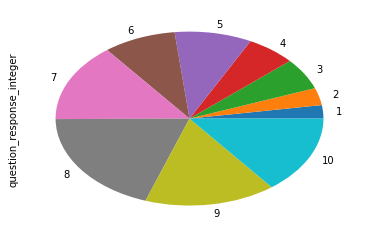

In [12]:
score_distribution.plot(kind='pie')

In [13]:
category_distribution = responses_df['industry_name'].value_counts().sort_index()

In [14]:
category_distribution

Arts & Entertainment                   463
Computer & Technology Hardware         124
Computer & Technology Software        6064
Construction & Facilities Services     793
Consumer Products & Services          2370
E-Commerce                             546
Education                              812
Energy & Utilities                     552
Finance & Insurance                   2416
Government & Non-Profit               1605
Hospitality                            806
IT Consulting                         1233
Manufacturing                          511
Marketing & Advertising               2215
Medicine & Health                     2573
Other                                 2461
Professional Consulting Services      2672
Retail & Wholesale                     908
Telecommunications                     389
Transportation & Logistics             468
Name: industry_name, dtype: int64

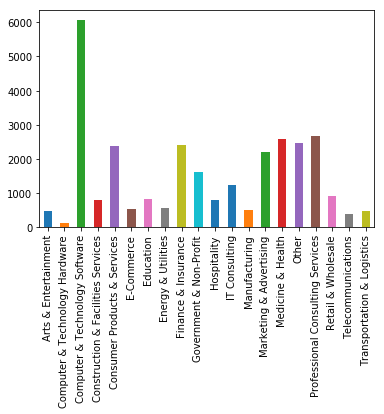

In [15]:
category_distribution.plot(kind='bar')

In [16]:
responses_df['question_response_integer'].describe()

count    29981.000000
mean         6.952203
std          2.398886
min          1.000000
25%          5.000000
50%          7.000000
75%          9.000000
max         10.000000
Name: question_response_integer, dtype: float64

# Classify the response score into 3 type: 

- 1,2,3,4 -> Negative
- 5,6-> Neutral
- 7,8,9,10 -> Positive

In [17]:
def sentiment_score(score):
    if score < 5:
        return 1 #'negative'
    elif score > 6:
        return 0 #'positive'
    else:
        return 2 #'neutral'

In [18]:
responses_df['sentiment'] = responses_df['question_response_integer'].progress_apply(sentiment_score)

In [19]:
responses_df.head(10)

,Unnamed: 0,id,submitted_at,survey_id,industry_name,question_response_integer,question_response_more,sentiment
0,0,18429574,2018-01-08 20:17:20,333628,Telecommunications,10,"I love the leadership team here, and the fact ...",0
1,1,18499545,2018-01-03 18:08:08,333628,Telecommunications,7,"While its exciting that we're growing so fast,...",0
2,2,18499546,2018-01-03 22:59:53,333628,Telecommunications,9,I like the people I work with. Everyone is re...,0
3,3,18499576,2018-01-03 22:04:15,333628,Telecommunications,7,Great people; great Industry; Great collabora...,0
4,4,18499587,2018-01-03 23:21:50,333628,Telecommunications,7,Always room for improvement.,0
5,5,18432012,2018-01-03 14:38:39,333683,Computer & Technology Software,10,Pumped and loving hanging with the team,0
6,6,18499732,2018-01-03 18:28:12,334413,Government & Non-Profit,4,The reorganization and string of firings this ...,1
7,7,18499747,2018-01-03 18:41:39,334413,Government & Non-Profit,1,I'm not sure what is happening but lately it's...,1
8,8,18499755,2018-01-03 18:34:39,334413,Government & Non-Profit,7,Tolerance and respect seems to be lacking at t...,0
9,9,18499757,2018-01-03 19:44:52,334413,Government & Non-Profit,4,I would like my manager to communicate with a ...,1


# Take a look with the sentiment:

In [20]:
responses_df['sentiment'].value_counts()

0    19322
2     5422
1     5237
Name: sentiment, dtype: int64

**Look like the number of `Negative` responses is quite small, it could affect the training for predicting the Negative, but keep going with the input data, we will improve the data input later**

**_TODO_**: Increase the response with `Negative` value, so that the model could recognize the `Negative` response better (**we hope**)

**Result**: We tried to classify the Negative, Positive and Neutral value of a response by looking at the chart and the distribution of score value:
* At the first time, we try to balance the number of response in Neg, Pos and Neu, but the accuracy is going down:
 * 9,10 -> Positive
 * 6,7,8 -> Neutral
 * 1,2,3,4,5 -> Negative

* Then we try to increase the Neutral value, and balance for the Positive and Negative that mean we have more neutral response, but the accuracy value is not increased:
 * 9,10 -> Positive
 * 5,6,7,8 -> Neutral
 * 1,2,3,4 -> Negative

**Getting the dataframe for processing data:**

In [21]:
nlp_df = responses_df[['question_response_more', 'sentiment']]

In [22]:
nlp_df.head(20)

,question_response_more,sentiment
0,"I love the leadership team here, and the fact ...",0
1,"While its exciting that we're growing so fast,...",0
2,I like the people I work with. Everyone is re...,0
3,Great people; great Industry; Great collabora...,0
4,Always room for improvement.,0
5,Pumped and loving hanging with the team,0
6,The reorganization and string of firings this ...,1
7,I'm not sure what is happening but lately it's...,1
8,Tolerance and respect seems to be lacking at t...,0
9,I would like my manager to communicate with a ...,1


**Using regular expression to remove not alphabet character, by replacing them with space character:**

In [23]:
import re
first_text=nlp_df.question_response_more[71]
text=re.sub("[^a-zA-Z]"," ",first_text) #changing characters with space
text=text.lower()

**Lets review of changing:**

In [24]:
print(nlp_df.question_response_more[71])
print(text)

I feel that there is a lot of uncertainty amongst employees all over of what the future holds for them at Q4.  
i feel that there is a lot of uncertainty amongst employees all over of what the future holds for them at q    


### Stopwords

In [25]:
#stopwords (irrelavent words)
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')
from nltk.corpus import stopwords
text=nltk.word_tokenize(text) #separate all words

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/khuyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/khuyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/khuyen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [26]:
text

['i',
 'feel',
 'that',
 'there',
 'is',
 'a',
 'lot',
 'of',
 'uncertainty',
 'amongst',
 'employees',
 'all',
 'over',
 'of',
 'what',
 'the',
 'future',
 'holds',
 'for',
 'them',
 'at',
 'q']

### Lemmatization: 
ex: employees --> employee

In [27]:
import nltk as nlp
lemma=nlp.WordNetLemmatizer()
text=[lemma.lemmatize(i) for i in text]
text=" ".join(text)
text

'i feel that there is a lot of uncertainty amongst employee all over of what the future hold for them at q'

## Applying tokenize and lemmatize for all response text

In [28]:
text_list=[]
for resp in nlp_df.question_response_more:
    text=re.sub("[^a-zA-Z]"," ",str(resp))
    text=text.lower()
    text=nltk.word_tokenize(text)
    lemma=nlp.WordNetLemmatizer()
    text=[lemma.lemmatize(word) for word in text]
    text=" ".join(text)
    text_list.append(text)

In [29]:
text_list[:10]

['i love the leadership team here and the fact that there is unlimited room for growth i ve never worked somewhere where the people cared so much',
 'while it exciting that we re growing so fast it definitely can make me feel uneasy at time not knowing what s ahead for this company i e not even knowing our plan for even three month out it make job security and projected growth a little hard to know be confident in',
 'i like the people i work with everyone is really kind',
 'great people great industry great collaboration and innovation mediocre compensation recognition and influence',
 'always room for improvement',
 'pumped and loving hanging with the team',
 'the reorganization and string of firing this summer wa disgracefully handled it turned my feeling about the organization from very positive and family like to disgust',
 'i m not sure what is happening but lately it s becoming a little bit toxic in here i can see that people are very grumpy and unhappy',
 'tolerance and respect

## bag of words

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
max_features=400000
cou_vec=CountVectorizer(max_features=max_features,stop_words="english")
sparce_matrix=cou_vec.fit_transform(text_list).toarray()
all_words=cou_vec.get_feature_names()
print("Most used words: ", all_words[0:100])

Most used words:  ['aa', 'aaa', 'aaaalllllll', 'aae', 'aaha', 'aalwys', 'aam', 'aan', 'aangetrokken', 'aangezien', 'aantoont', 'aardig', 'aaron', 'aarp', 'aat', 'ab', 'aba', 'aback', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abb', 'abbe', 'abbie', 'abby', 'abel', 'abernathy', 'abg', 'abhisheka', 'abi', 'abide', 'abided', 'abiding', 'abiguous', 'abililties', 'ability', 'abilkity', 'abit', 'able', 'abnormal', 'abnormality', 'abnormally', 'aboard', 'abolished', 'abolishing', 'abou', 'abound', 'abounds', 'aboutgolf', 'abraham', 'abrasion', 'abrasive', 'abroad', 'abrupt', 'abruptly', 'absence', 'absent', 'absenteeism', 'absolute', 'absoluteley', 'absolutely', 'absolutley', 'absolutly', 'absolve', 'absorb', 'absorbed', 'absorption', 'abstract', 'abstraction', 'absurd', 'abt', 'abu', 'abundance', 'abuse', 'abused', 'abusing', 'abusive', 'abvancement', 'abw', 'abysmal', 'abyss', 'ac', 'academic', 'academically', 'academy', 'accelerate', 'accelerated', 'accelerates', 'accelerating',

Now we have the sparce matrix and vectorize all the response text

## Visualize the words with wordcloud

In [31]:
from wordcloud import WordCloud

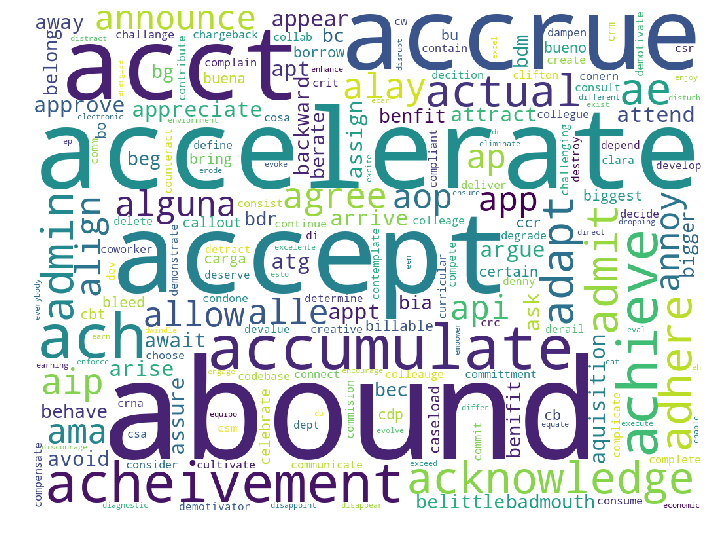

In [32]:
plt.subplots(figsize=(12,12))
wordcloud=WordCloud(background_color="white",width=1024,height=768).generate(" ".join(all_words))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Splitting test for building model and test

In [33]:
y=nlp_df.iloc[:,1].values
x=sparce_matrix
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

## Random Forest:

In [34]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, random_state=42)
rf.fit(x_train,y_train)
print("accuracy: ",rf.score(x_test,y_test))

/Users/khuyen/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


accuracy:  0.6588294147073537


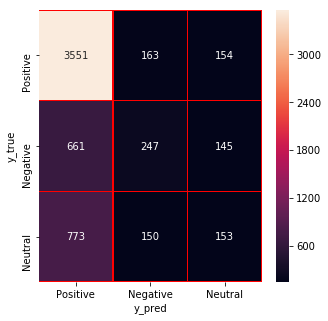

In [35]:
#confussion matrix
y_pred=rf.predict(x_test)
y_true=y_test
from sklearn.metrics import confusion_matrix
import seaborn as sns
names=["Positive","Negative","Neutral"]
cm=confusion_matrix(y_true,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

## Logistic Regression

In [36]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(x_train,y_train)
print("lr accuracy: ",lr.score(x_test,y_test))

lr accuracy:  0.6831749207937302


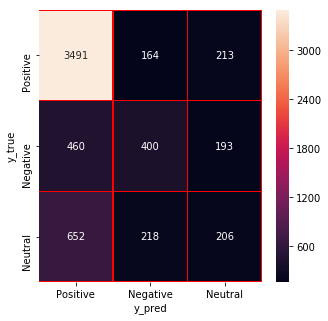

In [37]:
#confussion matrix
y_pred=lr.predict(x_test)
y_true=y_test
from sklearn.metrics import confusion_matrix
import seaborn as sns
names=["Positive","Negative","Neutral"]
cm=confusion_matrix(y_true,y_pred)
f,ax=plt.subplots(figsize=(5,5))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)
plt.show()

**Test Size = 5997**
Predict False Positives:
- Negative -> Positive : 460
- Negative -> Neutral : 193

**%False Positives in dangerous zone :**

In [38]:
(460+193)/5997

0.1088877772219443

**~10.9%**

**So, we are safe for predict with the text with acceptable percentage = 100 - 10.9 = 89.1%**

**We can use the trained model for predicting the text question which have the meaning similar to happiness question**